In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input,optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float'

In [5]:
# INIT
# PART 1
number_samples = [128, 256, 512, 1024, 2048, 4096] 
validation_size, noise_floor = 0.2, -110.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 299, 299, 3, 60  # su_size:30 for 1000, 10 for 100
cell_size, pixel_expansion = 1000 / max_x, max_x / 100
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope = 'log', 5  # 'log', 'linear', slope 3 for 1000, 5 for 100
max_pus_num, max_sus_num = 20, 5
propagation_model = 'splat' # 'splat', 'log', 'testbed'
noise, std = False, 1 # False for splat
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors = False
if sensors:
    sensors_num = 3600
    sensors_file_path = f"data/sensors/square{100}/{sensors_num}/sensors.txt"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 14
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '_transfer/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (intensity_degradation + '_' + str(slope))) + (
    "/" + str(sensors_num) + "sensors" if sensors else "/pus_" + str(max_sus_num) + "_sus_3_channels_2") + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [6]:
image_dir

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_5_sus_3_channels_2/images'

(array([4.000e+00, 8.000e+00, 9.000e+00, 1.300e+01, 1.500e+01, 5.300e+01,
        6.600e+01, 1.080e+02, 1.310e+02, 2.120e+02, 2.690e+02, 3.580e+02,
        4.330e+02, 5.630e+02, 7.320e+02, 8.800e+02, 1.001e+03, 1.177e+03,
        1.232e+03, 1.243e+03, 1.321e+03, 1.247e+03, 1.141e+03, 1.112e+03,
        1.105e+03, 9.830e+02, 9.790e+02, 9.170e+02, 9.040e+02, 7.910e+02,
        7.760e+02, 7.500e+02, 7.490e+02, 6.930e+02, 6.710e+02, 6.390e+02,
        5.860e+02, 5.990e+02, 5.850e+02, 5.730e+02, 4.850e+02, 5.060e+02,
        4.900e+02, 5.070e+02, 4.380e+02, 3.890e+02, 3.420e+02, 2.520e+02,
        2.060e+02, 1.610e+02, 1.360e+02, 7.600e+01, 5.800e+01, 5.500e+01,
        3.300e+01, 3.700e+01, 3.200e+01, 1.800e+01, 2.200e+01, 2.000e+01,
        2.000e+01, 1.000e+01, 9.000e+00, 8.000e+00, 3.000e+00, 7.000e+00,
        3.000e+00, 7.000e+00, 6.000e+00, 1.000e+00, 2.000e+00, 5.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 2.000e+0

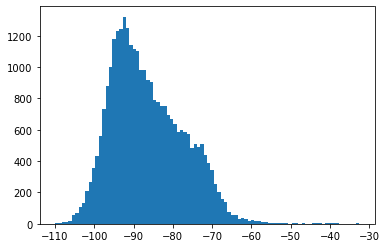

In [11]:
plt.hist(data_reg[:, 0:1:sensors_num], bins='auto')

In [3]:
# LOAD DATA
num_columns = (sensors_num if sensors else max_pus_num * 3 + 1) + max_sus_num * 3 + 2
cols = [i for i in range(num_columns)]
dataset_name = "dynamic_pus_using_pus_70000_min10_max20PUs_min1_max5SUs_square100grid_splat_2021_10_19_17_54.txt"
max_dataset_name = "dynamic_pus_max_power_70000_min10_max20PUs_min1_max5SUs_square100grid_splat_2021_10_19_17_54.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name + "\n")
    set_file.write(max_dataset_name)

dataframe = pd.read_csv('data/' 
                        + dataset_name, delimiter=',', header=None, names=cols)
dataframe_max = pd.read_csv('data/' 
                            + max_dataset_name, delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)
dataframe_max[dataframe_max.shape[1] - 1] = dataframe_max[dataframe_max.shape[1] - 1].astype(float)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]], axis=1,
                        ignore_index=True)

idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)

data_reg = dataframe_tot.values
data_reg[data_reg < noise_floor] = noise_floor

if sensors:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
del dataframe, dataframe_tot, dataframe_max

In [21]:
data_reg[0,:]

array([ 1.7000e+01,  8.7300e+02,  4.0400e+02, -1.9092e+01,  4.0000e+02,
        3.8800e+02, -1.3100e-01,  2.9600e+02,  4.2700e+02, -6.1270e+00,
        3.8200e+02,  5.9600e+02, -2.4876e+01,  5.1400e+02,  3.0000e+02,
       -2.3366e+01,  4.0900e+02,  9.7100e+02, -2.1624e+01,  3.1700e+02,
        6.3100e+02, -6.3680e+00,  9.0500e+02,  2.5300e+02, -3.4060e+00,
        5.5200e+02,  9.0300e+02, -1.3216e+01,  9.4500e+02,  3.6400e+02,
       -1.5166e+01,  1.6700e+02,  2.3100e+02, -1.0489e+01,  5.4600e+02,
        4.8700e+02, -3.3360e+00,  7.9000e+02,  8.4500e+02, -2.0724e+01,
        5.2300e+02,  1.4600e+02, -1.1942e+01,  3.1300e+02,  2.8700e+02,
       -1.8686e+01,  5.6000e+02,  4.5400e+02, -2.0979e+01,  6.0600e+02,
        6.5400e+02, -1.0700e+00,  3.0000e+00,  5.8500e+02,  2.2900e+02,
        2.6713e+01,  4.5900e+02,  2.4800e+02,  1.6271e+01,  6.6100e+02,
        9.1000e+02,  5.4173e+01,  0.0000e+00,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [7]:
data_reg = data_reg[:10000][:]

In [14]:
data_reg_train = data_reg[12000][:]

In [22]:
data_reg.shape

(30000, 79)

In [24]:
np.min(data_reg[:, -1])

-76.33

In [8]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5 * cell_size

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle',
                 pu_param=None, su_shape='circle', su_param=None, intensity_degradation="log", 
                 max_pu_power: float=0, max_su_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((max_x, max_y, number_image_channels), dtype=float_memory_used)
        if not sensors:
            pus_num = int(data[0])
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
                pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
                pu_p = data[pu_i * 3 + 3]
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y),
                                             shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[int(abs(pu_p))//10][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[point.p.x][point.p.y][0] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[point.p.x][point.p.y][0] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        else:
            ss_param, ss_shape = pu_param, pu_shape
            for ss_i in range(sensors_num):
                ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x * pixel_expansion))), max(
                    0, min(max_x-1, int(sensors_location[ss_i].y * pixel_expansion))), max(noise_floor, data[ss_i])
                ss_channel = 0 
#                 if -62.5 <= ss_p < -50.0:
#                     ss_channel = 1
#                 elif -75.0 <= ss_p < -62.6:
#                     ss_channel = 2
#                 elif -87.5 <= ss_p < -75.0:
#                     ss_channel = 3
#                 elif -100.0 <= ss_p < -87.5:
#                     ss_channel = 4
# #                 elif -70.0 <= ss_p < -65.0:
# #                     ss_channel = 5
#                 elif ss_p < -100.0:
#                     ss_channel = 5
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
                else:
                    ss_param_p = ss_param
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[point.p.x][point.p.y][ss_channel] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[point.p.x][point.p.y][ss_channel] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[point.p.x][point.p.y][ss_channel] += (ss_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1] * pixel_expansion)))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2] * pixel_expansion)))
            su_p = data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            su_param_p = get_pu_param(su_shape, intensity_degradation, su_p, noise_floor, slope)
            points = points_inside_shape(center=Point(su_x, su_y),
                                         param=su_param_p, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -2
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_su_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_su_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_su_power - noise_floor)
                    image[point.p.x][point.p.y][su_channel] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1] * pixel_expansion)))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2] * pixel_expansion)))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y),
                                     param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[point.p.x][point.p.y][su_channel] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        pus_num = int(data[0])
        for pu_i in range(pus_num):
            pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
            pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
            pu_p = data[pu_i * 3 + 3]
            
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                            max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        else:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
#                                 max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        
        # creating SU image
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
            
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1])))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2])))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image       
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-int(r/cell_size), -max_x), 
                             min(int(r/cell_size), max_x) + 1) 
                             for y in range(max(-r, -max_y), min(r, max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num, image_dir=image_dir):
    if False and style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
        suffix = 'npz'  # npy, npz
#         image = np.load(f"{image_dir}{image_num//100000}/image{image_num}.{suffix}") 
        image = np.load(f"{image_dir}/image{image_num}.{suffix}") 
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image

In [186]:
data_img_train[0] = image

In [212]:
data_reg_train = np.repeat(data_reg[:2048], 4, axis=0)
image_state = ["", "rot", "lr", "ud"] * 2048
p = np.random.permutation(2048*4)
data_reg_train = data_reg_train[p]
new_image_state = []
for idx in range(2048*4):
    new_image_state.append(image_state[p[idx]])

In [11]:
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg_train[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0)
        if new_image_state[image_num] == "rot":
            image = np.rot90(image, 2)
        elif new_image_state[image_num] == "lr":
            image = np.fliplr(image)
        elif new_image_state[image_num] == "ud":
            image = np.flipud(image)
        np.savez_compressed(image_dir + '/image' + str(image_num), a=np.expand_dims(image,0 ))
        
        del image

In [223]:
jobs = []
proc_sizes = [data_reg_train.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg_train.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|██████████| 819/819 [14:16<00:00,  1.05s/it]


In [9]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0 if not sensors else -30)
        if False and style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
    #         np.save(image_dir + '/image' + str(image_num), image)
#             np.savez_compressed(f"{image_dir}{(600000 + image_num)//100000}/image{600000 + image_num}",
#                                 a=np.expand_dims(image,0))
            np.savez_compressed(f"{image_dir}/image{image_num}",
                                a=np.expand_dims(image,0))
        del image

In [15]:
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|█████████████████████████████████████████| 714/714 [11:46<00:00,  1.01it/s]


In [21]:
data_reg[2,:]

array([ 11.   ,   4.   ,  25.   ,  -6.818,  35.   ,  95.   ,  -0.287,
        60.   ,  90.   , -26.266,  86.   ,  89.   ,  -5.14 ,  52.   ,
        70.   , -20.486,   1.   ,  35.   ,  -2.297,   5.   ,   6.   ,
       -17.296,   3.   ,  69.   ,  -2.296,  27.   ,  35.   ,  -6.15 ,
        96.   ,  62.   ,  -5.406,  12.   ,  54.   ,  -5.032,   3.   ,
        71.   ,  55.   ,  17.339,  27.   ,  72.   , -45.29 ,  61.   ,
        59.   ,  10.213,   0.   ,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan, -48.57 ])

In [86]:
imm = read_image(5876)
new_imm = np.zeros((max_x, max_y), dtype=float_memory_used)
for x in range(max_x):
    for y in range(max_y):
        new_imm[x][y] = imm[0][x][y][-1]

In [21]:
np.min(data_reg[:,-1])

-39.905

In [13]:
imm = read_image(0)#, image_dir="/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/images")
immm = np.zeros((max_x, max_y, number_image_channels), dtype='float')
for x in range(max_x):
    for y in range(max_y):
        for ch in range(number_image_channels):
            immm[x][y][ch] = float(imm[0][x][y][ch])

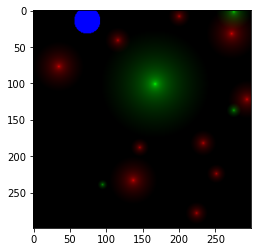

In [14]:
immm[immm>1] = 1.0
plt.imshow(immm)

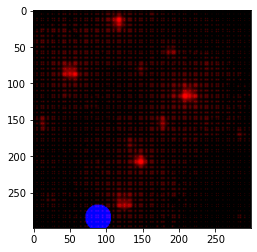

In [71]:
immm[immm>1] = 1.0
plt.imshow(immm)

In [67]:
best_model1.predict(imm)

NameError: name 'best_model1' is not defined

In [17]:
data_reg[0,:]

array([ 1.8000e+01,  8.0500e+02,  8.1400e+02, -1.6198e+01,  6.3600e+02,
        4.6000e+02, -1.9320e+01,  8.0400e+02,  8.9000e+02, -6.3000e+00,
        3.3300e+02,  3.0300e+02, -6.4020e+00,  7.0000e+02,  5.4600e+02,
       -2.8245e+01,  9.5000e+01,  3.0000e+00, -6.1280e+00,  9.9700e+02,
        7.3600e+02, -1.8048e+01,  1.3000e+01,  1.6900e+02, -1.0415e+01,
        9.4500e+02,  1.0600e+02, -1.6778e+01,  5.5100e+02,  6.5400e+02,
       -1.6303e+01,  7.3600e+02,  5.6000e+02, -2.6173e+01,  3.1000e+02,
        6.8500e+02, -2.7224e+01,  5.1800e+02,  1.0900e+02, -6.5100e-01,
        1.9400e+02,  5.3600e+02, -5.3040e+00,  5.1000e+02,  2.1800e+02,
       -2.2131e+01,  1.4800e+02,  7.5300e+02, -2.3959e+01,  9.3800e+02,
        2.1600e+02, -1.0055e+01,  5.6700e+02,  3.4300e+02, -1.6463e+01,
        1.0000e+00,  9.4100e+02,  8.4900e+02,  9.2370e+00,  1.0000e+00,
               nan,         nan,         nan,         nan,         nan,
               nan,  1.7221e+01])

In [102]:

img_rot = ndimage.rotate(immm, -90, reshape=False)
img_rot = np.rot90(immm,2)
plt.imshow(img_rot)


NameError: name 'ndimage' is not defined

<AxesSubplot:>

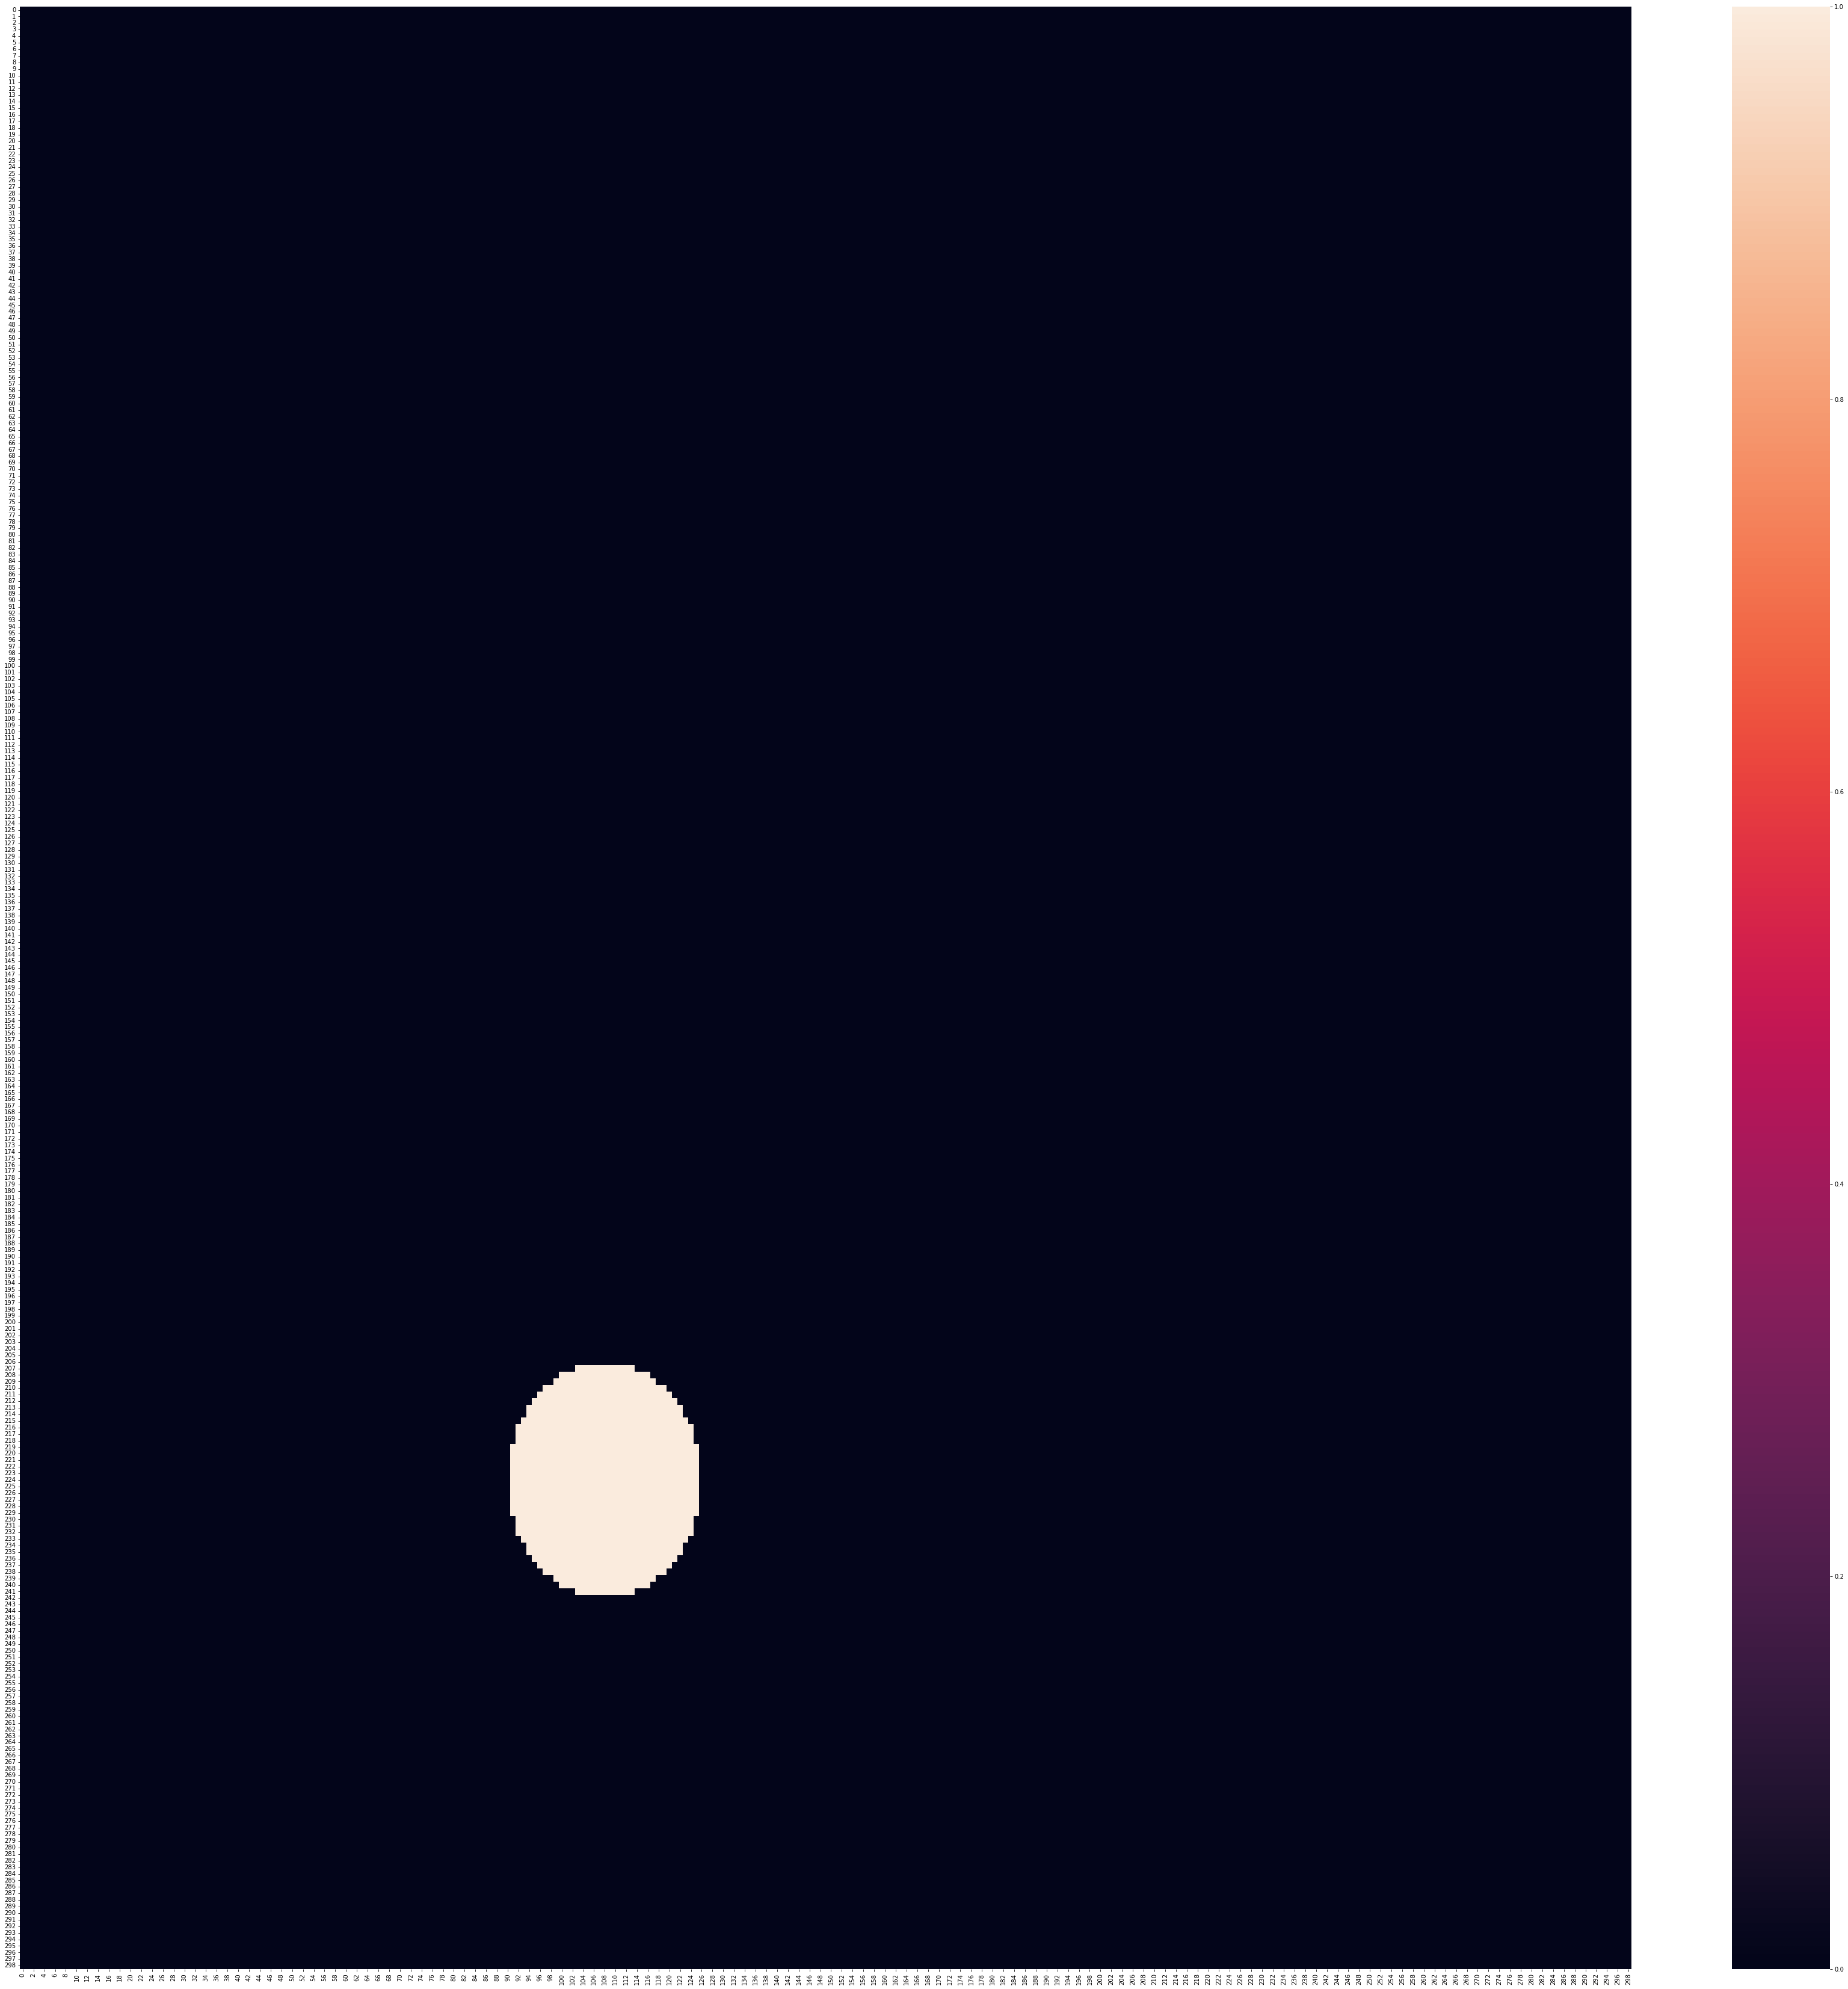

In [87]:

fig, ax = plt.subplots(figsize=(60,60))         # Sample figsize in inches
sns.heatmap(new_imm, ax=ax)

In [16]:
def cnn_model(kernel_lam, bias_lam):
    inputs = Input(shape=(max_x, max_y, number_image_channels))
    convolution_filter, dense_filter = 'relu', 'linear'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # learn in a few paragraphs.
    base_model.trainable = False
    cnn = base_model(inputs, training=False)
    
#     cnn = layers.Dense(1024, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
#                              bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
#     cnn = layers.Dropout(0.5)(cnn)
    if True:
        # Convert features of shape `base_model.output_shape[1:]` to vectors
        cnn = layers.GlobalAveragePooling2D()(cnn)
        cnn = layers.Dense(1024, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
        cnn = layers.Dropout(0.5)(cnn)
        outputs = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init)(cnn)
        return Model(inputs, outputs)
    else:
        data_format="channels_last"
        filter_shape, pool_size = (1, 1), (2,2)
        cnn = layers.Conv2D(512, filter_shape, padding='same', 
                            activation=convolution_filter, data_format=data_format, 
                            kernel_regularizer=regularizers.l2(kernel_lam), 
                            bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(128, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(32, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(8, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(1, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.GlobalAveragePooling2D()(cnn)
        return Model(inputs, cnn)
    

class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, image_dir = image_dir, conserve=0):
#         print(dataset.shape[0])
#         print("generator initiated")
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
        self._image_dir = image_dir
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
#         print('generator yielded a batch %d' % idx)
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.max_x, self.max_y, self.number_image_channels), dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i, self._image_dir)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)


In [45]:
# Xception model
model_name = "resnet101"
base_model = applications.ResNet101V2(include_top=False, weights='imagenet',
                                input_shape=(max_x, max_y, number_image_channels))
base_model.trainable = False
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [17]:
# log-vgg pretrained
model_name = "log_vgg16"
fp_penalty_coef, fn_penalty_coef = 1, 1
base_model = models.load_model("ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/" + 
                               "raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels_700k/models/700000/" +
                               "best_model_lambda_0_fit.h5", 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
base_model.trainable = False
base_model = base_model.layers[1]
base_model.summary()

2021-10-20 11:00:24.833165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 11:00:24.837182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 11:00:24.837483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 11:00:24.838413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [18]:
cnn1 = cnn_model(0, 0)

In [19]:
cnn1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
___________________________________________

In [16]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [51]:
number_samples = [128, 256, 512, 1034, 2048, 4096]

In [20]:
number_samples = [1024]

In [19]:
number_samples = [700000]
number_sample = number_samples[0]

In [ ]:
# CNN: support batching
TEST, CONSERVE = True, False
mini_batch = 16 if max(max_x, max_y) == 1000 else 64
epochs = 35 if max(max_x, max_y) == 1000 else 200
MAX_QUEUE_SIZE, WORKERS = 28, 4
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0.1] 
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns = []
if CONSERVE: # for conservative
    prev_number_samples = [0] + number_samples[:-1]

for num_sample_idx, number_sample in enumerate(number_samples):
    if CONSERVE:
        data_reg[prev_number_samples[num_sample_idx]:number_sample, -1] = data_reg[
            prev_number_samples[num_sample_idx]:number_sample, -1] - 1 # conserv value
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + model_name + "/" + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(1e-4), 
                        metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb)+ '.h5',
                                         verbose=1, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb in lambda_vec]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb in lambda_vec]
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
#     val_size = 50000
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=2,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
    # ******************** fine-tunning *******
    print("******FINE TUNNING ******")
    # reloading the best
    cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'}) for lamb in lambda_vec]
    for cnn in cnns:
        cnn.trainable = True
        cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                    optimizer=optimizers.Adam(1e-5), 
                    metrics=['mse', 'mae', fp_mae])
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch//2,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch//2,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=int(epochs//2), verbose=2,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
    
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator, checkpointers
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(lambda_vec[best_lamb_idx]) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if False:
            test_generator_conserve = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/models/' + model_name + "/"
                     + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve],
                    file=var_f)
        var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 1024 , New samples: 1024
Validation size: 205 , starts: 1024 , ends: 1228


2021-10-20 11:01:13.019440: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-10-20 11:01:14.469300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2021-10-20 11:01:20.093782: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


16/16 - 12s - loss: 705.0249 - mse: 604.3942 - mae: 19.3058 - fp_mae: 10.7494 - val_loss: 339.0038 - val_mse: 240.4615 - val_mae: 13.1547 - val_fp_mae: 5.4397

Epoch 00001: val_mae improved from inf to 13.15469, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_5_sus_3_channels_2/models/log_vgg16/1024/best_model_lambda_0.1.h5
Epoch 2/200
16/16 - 4s - loss: 572.1214 - mse: 475.3494 - mae: 17.2456 - fp_mae: 10.3149 - val_loss: 290.9617 - val_mse: 196.1535 - val_mae: 11.9040 - val_fp_mae: 4.7108

Epoch 00002: val_mae improved from 13.15469 to 11.90396, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_5_sus_3_channels_2/models/log_vgg16/1024/best_model_lambda_0.1.h5
Epoch 3/200
16/16 - 4s - loss: 496.7470 - mse: 403.6073 - mae: 15.7315 - fp_mae: 7.2297 - val_loss: 255.6240 - val_mse: 164.3418 - val_mae: 10.7562 - val_fp_mae: 5.2530

Epoch 00003: val_mae i

16/16 - 4s - loss: 217.4315 - mse: 166.7898 - mae: 9.7479 - fp_mae: 4.9336 - val_loss: 139.1498 - val_mse: 89.1326 - val_mae: 7.4305 - val_fp_mae: 3.1272

Epoch 00023: val_mae improved from 7.51849 to 7.43047, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_5_sus_3_channels_2/models/log_vgg16/1024/best_model_lambda_0.1.h5
Epoch 24/200
16/16 - 4s - loss: 226.0255 - mse: 176.5400 - mae: 10.1541 - fp_mae: 5.5468 - val_loss: 137.8513 - val_mse: 88.9578 - val_mae: 7.4298 - val_fp_mae: 3.6021

Epoch 00024: val_mae improved from 7.43047 to 7.42979, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_5_sus_3_channels_2/models/log_vgg16/1024/best_model_lambda_0.1.h5
Epoch 25/200
16/16 - 4s - loss: 228.5058 - mse: 180.1148 - mae: 10.2535 - fp_mae: 5.4078 - val_loss: 143.0905 - val_mse: 95.2597 - val_mae: 7.6771 - val_fp_mae: 2.5650

Epoch 00025: val_mae did not 


Epoch 00053: val_mae did not improve from 7.04727
Epoch 54/200
16/16 - 4s - loss: 137.0581 - mse: 104.9753 - mae: 7.9893 - fp_mae: 4.1916 - val_loss: 116.2644 - val_mse: 84.3201 - val_mae: 7.0780 - val_fp_mae: 3.1981

Epoch 00054: val_mae did not improve from 7.04727
Epoch 55/200
16/16 - 4s - loss: 130.5186 - mse: 98.6924 - mae: 7.6899 - fp_mae: 4.0970 - val_loss: 114.9635 - val_mse: 83.2695 - val_mae: 7.0539 - val_fp_mae: 3.1476

Epoch 00055: val_mae did not improve from 7.04727
Epoch 56/200
16/16 - 4s - loss: 129.9926 - mse: 98.4126 - mae: 7.7718 - fp_mae: 4.1503 - val_loss: 114.6461 - val_mse: 83.1931 - val_mae: 7.0835 - val_fp_mae: 2.9317

Epoch 00056: val_mae did not improve from 7.04727
Epoch 57/200
16/16 - 4s - loss: 132.5923 - mse: 101.2481 - mae: 7.9436 - fp_mae: 4.1292 - val_loss: 114.0383 - val_mse: 82.8161 - val_mae: 7.0212 - val_fp_mae: 3.1461

Epoch 00057: val_mae improved from 7.04727 to 7.02118, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circl

16/16 - 4s - loss: 100.2725 - mse: 73.3324 - mae: 6.6201 - fp_mae: 3.7243 - val_loss: 110.0910 - val_mse: 83.1951 - val_mae: 7.0766 - val_fp_mae: 2.8880

Epoch 00089: val_mae did not improve from 7.00550
Epoch 90/200
16/16 - 4s - loss: 98.3739 - mse: 71.5185 - mae: 6.6684 - fp_mae: 3.4011 - val_loss: 109.4828 - val_mse: 82.6733 - val_mae: 7.0362 - val_fp_mae: 3.1055

Epoch 00090: val_mae did not improve from 7.00550
Epoch 91/200
16/16 - 4s - loss: 100.7539 - mse: 73.9832 - mae: 6.7397 - fp_mae: 3.5573 - val_loss: 109.4339 - val_mse: 82.7078 - val_mae: 7.0473 - val_fp_mae: 3.0856

Epoch 00091: val_mae did not improve from 7.00550
Epoch 92/200
16/16 - 4s - loss: 98.9321 - mse: 72.2437 - mae: 6.6585 - fp_mae: 3.3842 - val_loss: 109.9324 - val_mse: 83.2873 - val_mae: 7.0466 - val_fp_mae: 3.0843

Epoch 00092: val_mae did not improve from 7.00550
Epoch 93/200
16/16 - 4s - loss: 101.3330 - mse: 74.7256 - mae: 6.7372 - fp_mae: 3.6803 - val_loss: 108.9693 - val_mse: 82.4038 - val_mae: 7.0010 - 


Epoch 00122: val_mae did not improve from 6.91305
Epoch 123/200
16/16 - 4s - loss: 82.5446 - mse: 57.9332 - mae: 6.0484 - fp_mae: 3.1295 - val_loss: 106.9485 - val_mse: 82.3673 - val_mae: 7.0399 - val_fp_mae: 2.8847

Epoch 00123: val_mae did not improve from 6.91305
Epoch 124/200
16/16 - 4s - loss: 88.6770 - mse: 64.1235 - mae: 6.3489 - fp_mae: 3.3274 - val_loss: 107.1474 - val_mse: 82.6238 - val_mae: 7.0278 - val_fp_mae: 3.1894

Epoch 00124: val_mae did not improve from 6.91305
Epoch 125/200
16/16 - 4s - loss: 84.4523 - mse: 59.9556 - mae: 6.0478 - fp_mae: 3.0721 - val_loss: 107.9967 - val_mse: 83.5312 - val_mae: 7.0738 - val_fp_mae: 3.0458

Epoch 00125: val_mae did not improve from 6.91305
Epoch 126/200
16/16 - 4s - loss: 87.2122 - mse: 62.7735 - mae: 6.1895 - fp_mae: 3.2914 - val_loss: 107.1857 - val_mse: 82.7776 - val_mae: 7.0178 - val_fp_mae: 3.1319

Epoch 00126: val_mae did not improve from 6.91305
Epoch 127/200
16/16 - 4s - loss: 88.4339 - mse: 64.0523 - mae: 6.2612 - fp_mae: 3

16/16 - 4s - loss: 77.3856 - mse: 54.5786 - mae: 5.8385 - fp_mae: 3.0806 - val_loss: 107.2088 - val_mse: 84.4247 - val_mae: 7.1277 - val_fp_mae: 2.8646

Epoch 00159: val_mae did not improve from 6.86827
Epoch 160/200
16/16 - 4s - loss: 79.3536 - mse: 56.5894 - mae: 5.8876 - fp_mae: 3.0790 - val_loss: 104.6780 - val_mse: 81.9371 - val_mae: 6.9938 - val_fp_mae: 3.1136

Epoch 00160: val_mae did not improve from 6.86827
Epoch 161/200
16/16 - 4s - loss: 75.0269 - mse: 52.3065 - mae: 5.6622 - fp_mae: 3.0245 - val_loss: 106.1501 - val_mse: 83.4523 - val_mae: 7.0306 - val_fp_mae: 2.7396

Epoch 00161: val_mae did not improve from 6.86827
Epoch 162/200
16/16 - 4s - loss: 72.7319 - mse: 50.0552 - mae: 5.6201 - fp_mae: 2.7757 - val_loss: 104.8686 - val_mse: 82.2172 - val_mae: 6.9932 - val_fp_mae: 3.1304

Epoch 00162: val_mae did not improve from 6.86827
Epoch 163/200
16/16 - 4s - loss: 78.2245 - mse: 55.5930 - mae: 5.8817 - fp_mae: 3.0402 - val_loss: 104.5303 - val_mse: 81.9220 - val_mae: 6.9910 -

16/16 - 4s - loss: 70.9834 - mse: 49.6878 - mae: 5.5522 - fp_mae: 2.9685 - val_loss: 103.7659 - val_mse: 82.4895 - val_mae: 7.0018 - val_fp_mae: 3.0781

Epoch 00196: val_mae did not improve from 6.86483
Epoch 197/200
16/16 - 4s - loss: 66.6024 - mse: 45.3435 - mae: 5.3270 - fp_mae: 2.6646 - val_loss: 105.0432 - val_mse: 83.8059 - val_mae: 7.0727 - val_fp_mae: 3.2562

Epoch 00197: val_mae did not improve from 6.86483
Epoch 198/200
16/16 - 4s - loss: 67.7440 - mse: 46.5240 - mae: 5.3672 - fp_mae: 2.8220 - val_loss: 104.3787 - val_mse: 83.1774 - val_mae: 7.0080 - val_fp_mae: 2.7486

Epoch 00198: val_mae did not improve from 6.86483
Epoch 199/200
16/16 - 4s - loss: 67.5249 - mse: 46.3401 - mae: 5.3424 - fp_mae: 2.8408 - val_loss: 102.5589 - val_mse: 81.3922 - val_mae: 6.9178 - val_fp_mae: 3.1209

Epoch 00199: val_mae did not improve from 6.86483
Epoch 200/200
16/16 - 4s - loss: 66.8324 - mse: 45.6816 - mae: 5.4028 - fp_mae: 2.7981 - val_loss: 102.1275 - val_mse: 80.9960 - val_mae: 6.8942 -


Epoch 00006: val_mae improved from 6.86248 to 6.84870, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_5_sus_3_channels_2/models/log_vgg16/1024/best_model_lambda_0.1.h5
Epoch 7/100
32/32 - 6s - loss: 59.3472 - mse: 37.3511 - mae: 4.8039 - fp_mae: 2.4642 - val_loss: 103.8531 - val_mse: 81.8642 - val_mae: 6.9312 - val_fp_mae: 3.0896

Epoch 00007: val_mae did not improve from 6.84870
Epoch 8/100
32/32 - 6s - loss: 56.5553 - mse: 34.5731 - mae: 4.5818 - fp_mae: 2.2506 - val_loss: 103.8547 - val_mse: 81.8798 - val_mae: 6.9502 - val_fp_mae: 3.3094

Epoch 00008: val_mae did not improve from 6.84870
Epoch 9/100
32/32 - 6s - loss: 56.1451 - mse: 34.1773 - mae: 4.6162 - fp_mae: 2.4707 - val_loss: 104.0408 - val_mse: 82.0804 - val_mae: 6.9725 - val_fp_mae: 3.2144

Epoch 00009: val_mae did not improve from 6.84870
Epoch 10/100
32/32 - 6s - loss: 54.7593 - mse: 32.8058 - mae: 4.5382 - fp_mae: 2.3055 - val_loss: 104.4721 - val_ms

32/32 - 6s - loss: 35.8543 - mse: 14.4040 - mae: 2.9922 - fp_mae: 1.5782 - val_loss: 106.1516 - val_mse: 84.7096 - val_mae: 7.0699 - val_fp_mae: 3.0225

Epoch 00044: val_mae did not improve from 6.84870
Epoch 45/100
32/32 - 6s - loss: 36.1754 - mse: 14.7415 - mae: 3.0608 - fp_mae: 1.5346 - val_loss: 103.1724 - val_mse: 81.7468 - val_mae: 6.9352 - val_fp_mae: 3.1501

Epoch 00045: val_mae did not improve from 6.84870
Epoch 46/100
32/32 - 7s - loss: 35.7609 - mse: 14.3431 - mae: 2.9954 - fp_mae: 1.5423 - val_loss: 104.8405 - val_mse: 83.4312 - val_mae: 6.9874 - val_fp_mae: 3.1793

Epoch 00046: val_mae did not improve from 6.84870
Epoch 47/100
32/32 - 6s - loss: 35.7149 - mse: 14.3136 - mae: 2.9624 - fp_mae: 1.5503 - val_loss: 104.5826 - val_mse: 83.1897 - val_mae: 7.0119 - val_fp_mae: 3.2316

Epoch 00047: val_mae did not improve from 6.84870
Epoch 48/100
32/32 - 6s - loss: 35.3538 - mse: 13.9686 - mae: 2.9220 - fp_mae: 1.5081 - val_loss: 104.1906 - val_mse: 82.8136 - val_mae: 6.9837 - val

32/32 - 7s - loss: 30.6637 - mse: 9.8758 - mae: 2.4474 - fp_mae: 1.3388 - val_loss: 108.1058 - val_mse: 87.3277 - val_mae: 7.1738 - val_fp_mae: 3.3027

Epoch 00082: val_mae did not improve from 6.84870
Epoch 83/100
32/32 - 6s - loss: 29.8530 - mse: 9.0843 - mae: 2.3193 - fp_mae: 1.2209 - val_loss: 107.6917 - val_mse: 86.9327 - val_mae: 7.1779 - val_fp_mae: 3.3470

Epoch 00083: val_mae did not improve from 6.84870
Epoch 84/100
32/32 - 6s - loss: 30.1586 - mse: 9.4085 - mae: 2.3974 - fp_mae: 1.1994 - val_loss: 107.5322 - val_mse: 86.7916 - val_mae: 7.1274 - val_fp_mae: 3.2348

Epoch 00084: val_mae did not improve from 6.84870
Epoch 85/100
32/32 - 6s - loss: 29.6439 - mse: 8.9126 - mae: 2.3144 - fp_mae: 1.2245 - val_loss: 107.7573 - val_mse: 87.0360 - val_mae: 7.1454 - val_fp_mae: 3.1044

Epoch 00085: val_mae did not improve from 6.84870
Epoch 86/100
32/32 - 7s - loss: 29.9679 - mse: 9.2560 - mae: 2.4047 - fp_mae: 1.2027 - val_loss: 106.5845 - val_mse: 85.8825 - val_mae: 7.1088 - val_fp_m

In [53]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)

[128, 256, 512, 1034, 2048, 4096]
[8.678, 7.595, 7.392, 6.968, 6.75]
[5.619, 4.375, 3.38, 3.669, 3.312]
[0.1, 0, 1, 10, 0.1]


In [ ]:
[128, 256, 512, 1024, 2048, 4096]
[8.678, 7.595, 7.392, 6.968, 6.701, 6.521]
[5.619, 4.375, 3.38,  4.032, 3.282, 3.4]
[0.1, 0, 1, 10, 0.1 0.1]

In [43]:
cnns[0].summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_41  (None, 512)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_41 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 1025      
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
________________________________________

In [128]:
base_model.trainable = True

In [140]:
cnns[0].summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_25  (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 1025      
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
________________________________________

In [17]:
number_sample

4096

In [24]:
train_generator = DataBatchGenerator(dataset=data_reg[0:number_sample], batch_size=16,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

val_size = math.ceil(number_sample * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                   batch_size=32,
                                   start_idx=number_sample,
                                   number_image_channels=number_image_channels,
                                   max_x=max_x, max_y=max_y, 
                                   float_memory_used=float_memory_used,
                                  )

In [246]:
train_generator = DataBatchGenerator(dataset=data_reg_train[prev_sample:number_sample], batch_size=16,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

val_size = math.ceil(number_sample/4 * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample//4:number_sample//4+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample//4,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

In [40]:
MODEL_PATH

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/2048/best_model_lambda_'

In [19]:
best_model = models.load_model(MODEL_PATH + str(0.1) + '.h5', 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
best_model.layers[1].trainable = True
best_model.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(1e-5), 
                        metrics=['mse', 'mae', fp_mae])

In [20]:
best_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 10, 10, 2048)      42626560  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1025      
Total params: 44,725,761
Trainable params: 44,628,097
Non-trainable params: 97,664
__________________________________________

In [21]:
checkpointers

In [25]:
best_model.fit(train_generator, epochs=60, verbose=0,
                   validation_data=val_generator, 
                   shuffle=True, callbacks=[checkpointers[0]], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False)


Epoch 00001: val_mae improved from 6.02357 to 4.56953, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/resnet101/4096/best_model_lambda_0.1.h5


/home/shahrokh/miniconda3/envs/research/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '



Epoch 00002: val_mae did not improve from 4.56953

Epoch 00003: val_mae improved from 4.56953 to 3.73990, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/resnet101/4096/best_model_lambda_0.1.h5

Epoch 00004: val_mae did not improve from 3.73990

Epoch 00005: val_mae did not improve from 3.73990

Epoch 00006: val_mae improved from 3.73990 to 3.73030, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/resnet101/4096/best_model_lambda_0.1.h5

Epoch 00007: val_mae did not improve from 3.73030

Epoch 00008: val_mae improved from 3.73030 to 3.67441, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/resnet101/4096/best_model_lambda_0.1.h5

Epoch 00009: val_mae improved from 3.67441 to 3.66329, saving model to ML/data/pi

In [27]:
best_model.save("ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/700000/best_model_lambda_0_fit.h5")

In [53]:
MODEL_PATH

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/log_vgg16/1024/best_model_lambda_'

In [62]:
number_sample + val_size+320*3

2189

In [27]:
best_model1 = models.load_model(MODEL_PATH + str(0.1) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                    batch_size=32,
                                    start_idx=number_sample + val_size, 
                                    number_image_channels=number_image_channels,
                                    max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
                                   image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_model1.evaluate(test_generator, verbose=1, 
                                workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
test_mae_idx, test_fp_mae_idx = [best_model1.metrics_names.index(mtrc) 
                                for mtrc in ['mae','fp_mae']]
test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
average_diff_power.append(round(test_mae, 3))
fp_mean_power.append(round(test_fp_mae, 3))
print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
        fp_mean_power[-1])

Test starts:  4916 , ends:  39999
1097/1097 [==============================] - 99s 89ms/step - loss: 21.4142 - mse: 18.6942 - mae: 3.2392 - fp_mae: 1.7789
average_error:  3.239 , fp_average_error:  1.779


In [149]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     